# Differentiation

We now get to our first computational problem: given a function, how can we approximate its derivative at a
point? Before we begin, we must be clear what a "function" is. Consider three possible scenarios:

1. _Black-box function_: Consider a function $f^{\rm FP} : F_{p} \rightarrow F_{p}$
(that is, we are given a double precision function that takes in a `Float64` and returns another `Float64`)
which we only know _pointwise_. This is the situation if we have a function that relies on a compiled C library.
Since $F_{64}$ is a discrete set such an $f^{\rm FP}$ cannot be differentiable in a rigorous way,
therefore we need to assume that $f^{\rm FP}$ approximates a differentiable function $f$ with controlled
error in order to state anything precise.
2. _Generic function_: Consider a function that is a piece of code that we can evaluate it on arbitrary types, including
custom types that we create. This is the case if we have a function defined in Julia that does not call any
C libraries. For analysis we typically consider both a differentiable function $f : {\mathbb R} \rightarrow {\mathbb R}$,
which would be what one would have if we could evaluate a function exactly using real arithmetic, and 
$f^{\rm FP} : F_{p} \rightarrow F_{p}$, which is what we actually compute when evaluating the function using 
floating point arithmetic.
3. _Graph function_: The function is built by composing different basic "kernels" with known differentiability properties.
We won't consider this situation in this module, though it is the model used by Python machine learning toolbox's
like [PyTorch](https://pytorch.org) and [TensorFlow](http://tensorflow.org).

We discuss the following techniques:

1. Finite-differences: this uses the definition of a derivative that one learns in calculus to approximate its value.
2. Dual numbers and forward-mode automatic differentiation: we define a special type that when applied to a function
computes its derivative. This unsafe_store! _dual numbers_, which is analoguous to complex numbers.
3. Adjoints and reverse-mode automatic differentiation: this is similar to applying the "chain rule" by building up
a tape of operations. It's outside the scope of this module but is important for machine learning.
4. Interpolation and differentiation: we can also differentiate functions _globally_, that is, in an interval instead of
only a single point, which will be discussed later in the module.


## 1. Finite-differences

The definition 
$$
f'(x) = \lim_{h \rightarrow 0} {f(x+h) - f(x) \over h}
$$
tells us that
$$
f'(x) \approx {f(x+h) - f(x) \over h}
$$
provided that $h$ is sufficiently small. 

It's important to note that approximation uses only the _black-box_
notion of a function but to obtain bounds we need more.

If we know a bound on $f''(x)$ then Taylor's theorem tells us a precise bound:

**Proposition**
The error in approximating the derivative using finite differences is
$$
\left|f'(x) - {f(x+h) - f(x) \over h}\right| \leq {\sup_{x \leq t \leq x+h} |f''(t)| \over 2 h}
$$

**Proof**
Follows immediately from Taylor's theorem:
$$
f(x+h) = f(x) + f'(x) h + {f''(\chi) \over 2} h^2
$$
for some $x < \chi < x+h$.

◼️




There are also alternative versions of finite differences. Leftside finite-differences:
$$
f'(x) ≈ {f(x) - f(x-h) \over h}
$$
and central differences:
$$
f'(x) ≈ {f(x + h/2) - f(x - h/2) \over h}
$$
Composing these approximations is useful for higher-order derivatives as we 
discuss in the problem sheet.



### Does finite-differences work with floating point arithmetic?

Note this is assuming _real arithmetic_, the answer is drastically
different with _floating point arithmetic_.

Let's try differentiating two simple polynomials $f(x) = x + x^2$ and $g(x) = 1 + x + x^2$
by applying the finite-difference approximation to their floating point implementations
$f^{\rm FP}$ and $g^{\rm FP}$:

In [1]:
f = x -> x + x^2     # we treat f and g as black-boxs
g = x -> 1 + x + x^2
h = 0.000001
(f(h)-f(0))/h, (g(h)-g(0))/h

(1.000001, 1.000001000006634)

Both seem to roughly approximate the true derivatives (`1`).
We can do a plot to see how fast the error goes down as we let $h$ become small.

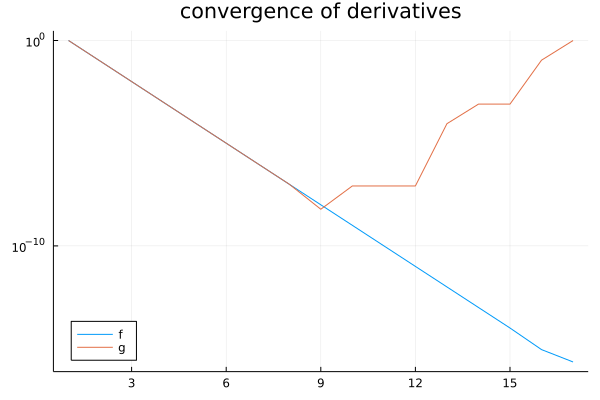

In [2]:
using Plots
h = 10.0 .^ (0:-1:-16)  # [1,0.1,0.01,…,1E-7]
plot(abs.((f.(h) .- f(0)) ./ h .- 1); yscale=:log10, title="convergence of derivatives", label="f", legend=:bottomleft)
plot!(abs.((g.(h) .- g(0)) ./ h .- 1); yscale=:log10, label = "g")

In the case of $f$ it is a success: we approximate the true derivative to roughly machine precision,
which is the best one can really hope for given round-off error (as the algebraic manipulation gets
the last bit will be wrong) by letting $h$ be sufficiently small.
But for $g$ it is a huge failure: the approximation starts to converge, but then diverges exponentially fast!

We can bound the error using the bounds on floating point arithmetic. For simplicity we ignore the
$x^2$ term: when $h$ is small, $h^2$ gets lost in the rounding. Then we have
$$
\left|((1 \oplus h) \ominus h) - 1 \oslash h -1\right| \leq ((1+h)*(1+\epsilon_{\rm machine}) - 1)*(1+\epsilon_{\rm machine}) = h + h \epsilon_{\rm machine} + O(h^2)
$$
Thus we see that the bound grows like $\epsilon_{\rm machine}/h$. However, a bad upper bound is not the same
as a proof that something grows, and establishing a lower bound on the error is more challenging. In fact,
it depends on the precise bits of $h$. 

Nevertheless, we can use this bound to obtain a _heuristic_ on how to choose $h$:

**Heuristic (finite-difference with floating-point step)** Choose $h$ proportional to $\sqrt{\epsilon_{\rm m}}$
in finite-differences.

**Sketch of argument**
Consider $x = 0$ assume $f(x) = f^{\rm FP}(0) = 0$ for simplicity, and suppose we have relative accuracy
$$
f^{\rm FP}(x) = f(x) + \delta
$$
where $|\delta| < c ϵ_{\rm m}$. Note that
$$
\begin{align*}
{f^{\rm FP}(h) \over h} &= {f(h) \over h} + {\delta \over h} = f'(0) + {h f''(0) \over 2} + {\delta \over h}  + O(h^2)
\end{align*}
$$
Choosing $h$ proportional to $\sqrt{ϵ_{\rm m}}$ tells us the error is proportional to $\sqrt{\epsilon_{\rm m}}$.

∎

In the case of double precision $\sqrt{ϵ_{\rm m}} ≈ 1.5\times 10^{-8}$, which is close to when the error begins to increase.


**Example (some functions do better than heuristic)** 
This heuristic is based on balancing terms in an upper bound, but a bad upper bound is not the same as a proof that an approximation is bad. 
And indeed, for our example
taking a step-size of $h = 2^q$ delivers much better results, and in fact gets the _exact_ answer for sufficiently
small `h`, down to the last bit!

In [3]:
h = 2.0 ^ (-30)
abs((g(h) - g(0)) / h - 1)

0.0

This is a quirk of this particular function and other functions will not be so lucky. But that said,
establishing a precise condition on when finite-difference is _guaranteed_ to be inaccurate is hard.


**Remark** While finite differences is of questionable utility for computing derivatives, it is extremely effective
in building methods for solving differential equations, as we shall see later.

## 2. Dual numbers (Forward-mode automatic differentiation)

Automatic differentiation consists of applying functions to special types that determine the derivatives.
Here we do so via _dual numbers_.

**Definition (Dual numbers)** Dual numbers ${\mathbb D}$ are a commutative ring over the reals 
generated by $1$ and $\epsilon$ such that $\epsilon^2 = 0$.
Dual numbers are typically written as $a + b \epsilon$ where $a$ and $b$ are real.

This is very much analoguous to complex numbers, which are a field generated by $1$ and ${\rm i}$ such that
${\rm i}^2 = -1$. Compare multiplication of each number type:
$$
\begin{align*}
(a + b {\rm i}) (c + d {\rm i}) &= ac + (bc + ad) {\rm i} + bd {\rm i}^2 = ac -bd + (bc + ad) {\rm i} \\
(a + b \epsilon) (c + d \epsilon) &= ac + (bc + ad) \epsilon + bd \epsilon^2 = ac  + (bc + ad) \epsilon 
\end{align*}
$$
And just as we view ${\mathbb R} \subset {\mathbb C}$ by equating $a \in {\mathbb R}$ with $a + 0{\rm i} \in {\mathbb C}$,
we can view ${\mathbb R} \subset {\mathbb D}$ by equating $a \in {\mathbb R}$ with $a + 0{\rm \epsilon} \in {\mathbb D}$.


### Matrix representations

Complex numbers can be thought of as $2 \times 2$ matrices, that is, $a + b {\rm i}$ is equivalent to
$$
a \underbrace{\begin{pmatrix}1 \\ & 1 \end{pmatrix}}_{\hbox{representation of 1}} + b \underbrace{\begin{pmatrix}0 &1 \\-1 & 0\end{pmatrix}}_{\hbox{representation of $\rm i$}} = \begin{pmatrix}a & b \\ -b & a \end{pmatrix}
$$
Similarly, for dual numbers we have
$$
a \underbrace{\begin{pmatrix}1 \\ & 1 \end{pmatrix}}_{\hbox{representation of 1}} + b \underbrace{\begin{pmatrix}0 &1 \\0 & 0\end{pmatrix}}_{\hbox{representation of $\epsilon$}} = \begin{pmatrix}a & b \\ 0 & a \end{pmatrix}
$$
That is, the representation of $\epsilon$ is a simple 2 × 2 nilpotent matrix.

### Connection with differentiation

Applying a polynomial to a dual number $a + b \epsilon$ tells us the derivative at $a$:

**Lemma (polynomials and dual numbers)** Suppose $p$ is a polynomial. Then
$$
p(a + b \epsilon) = p(a) + b p'(a) \epsilon
$$

**Proof**

It suffices to consider $p(x) = x^n$ for $n \geq 1$ as other polynomials follow from linearity. We proceed by induction:
The case $n = 1$ is trivial. For $n > 1$ we have 
$$
(a + b \epsilon)^n = (a + b \epsilon) (a + b \epsilon)^{n-1} = (a + b \epsilon) (a^{n-1} + (n-1) b a^{n-2} \epsilon) = a^n + b n a^{n-1} \epsilon.
$$

∎

We can extend real-valued differentiable functions to dual numbers in a similar manner.

**Definition (compatible extension)** Suppose a real-valued function $f$
is differentiable at $a$. If
$$
f(a + b \epsilon) = f(a) + b f'(a) \epsilon
$$
then we say that is a _compatible extension at $a$_.

Note this definition immediately implies the product and chain rule:

**Lemma (product and chain rule)**
Suppose $f$ is a compatible extension at $g(a)$ and $g$
is a compatible extension at $a$. Then $q(x) := f(g(x))$ and 
$r(x) := f(x) g(x)$ are compatible extensions at $a$, that is:
$$
\begin{align*}
q(a+b \epsilon) &= q(a) + b q'(b) \epsilon \\
r(a+b \epsilon) &= r(a) + b r'(b) \epsilon
\end{align*}
$$

**Proof**
For $q$ it follows immediately:
$$
q(a + b \epsilon) = f(g(a + b \epsilon)) = f(g(a) + b g'(a) \epsilon) = f(g(a)) + b g'(a) f'(g(a))\epsilon = q(a) + b q'(a) \epsilon
$$
For $r$ we have
$$
r(a + b \epsilon) = f(a+b \epsilon )g(a+b \epsilon )= (f(a) + b f'(a) \epsilon)(g(a) + b g'(a) \epsilon) = f(a)g(a) + b (f'(a)g(a) + f(a)g'(a)) \epsilon = r(a) +b r'(a) \epsilon
$$

∎

A simple corollary is that any function defined in terms of addition, multiplication, composition, etc.
of functions that are compatible with differentiation will be differentiable via dual numbers.

### Implementation in Julia

We now consider a simple implementation of dual numbers that works on polynomials:

In [4]:
struct Dual{T}
    a::T
    b::T
end

Dual(a::Real) = Dual(a, zero(a)) # for real numbers we use a + 0ϵ

import Base: +, *, -, /, ^, zero

# support polynomials like 1 + x, x - 1, 2x or x*2 by reducing to Dual
+(x::Real, y::Dual) = Dual(x) + y
+(x::Dual, y::Real) = x + Dual(y)
-(x::Real, y::Dual) = Dual(x) - y
-(x::Dual, y::Real) = x - Dual(y)
*(x::Real, y::Dual) = Dual(x) * y
*(x::Dual, y::Real) = x * Dual(y)

# support x/2 (but not yet division of duals
/(x::Dual, k::Real) = Dual(x.a/k, x.b/k)
# a simple recursive function to support x^2, etc.
function ^(x::Dual, k::Integer)
    if k < 0
        error("Not implemented")
    elseif k == 1
        x
    else
        x^(k-1) * x
    end
end

-(x::Dual) = Dual(-x.a, -x.b)
+(x::Dual, y::Dual) = Dual(x.a + y.a, x.b + y.b)
-(x::Dual, y::Dual) = Dual(x.a - y.a, x.b - y.b)
*(x::Dual, y::Dual) = Dual(x.a*y.a, x.a*y.b + x.b*y.a)

* (generic function with 447 methods)

We can now try it on an arbitrary polynomial:

In [5]:
f = x -> 1 + 1.3x + 2.1x^2 + 3.1x^3
f(Dual(0.5,1.0)).b - 5.725

8.881784197001252e-16

It's exact up apart from small rounding errors.

Now consider the polynomial $1 + … + x^n$. How does the error grow with $n$ evaluating
the derivative at $x = 0.5$ and $x = 1$?

In [6]:
function g(n, x)
    ret = 1 + x # first two terms
    for k = 2:n
        ret += x^k
    end
    ret
end

# "exact" derivative of g
function g′(n, x)
    ret = 1 + 2x # first two terms
    for k = 3:n
        ret += k*x^(k-1)
    end
    ret
end

g′(10, 0.1) - g(10, Dual(0.1,1.0)).b

LoadError: cannot define function g; it already has a value

It's exact!

What makes dual numbers so effective is that, unlike finite differences, they are not
prone to disasterous growth due to round-off errors. 


In the problem sheet we will explore implementation of other functions like `/` and `exp`.